# Inverse R-W with Poschl-Teller potential




In [ ]:
import deepxde as dde
import numpy as np
from deepxde.backend import tf
import matplotlib.pyplot as plt
import re

In [ ]:
#Unknown parameters

w_r = dde.Variable(1.0)  # Real part
w_i = dde.Variable(-1.0) # Imaginary part
n = 3                    # mode
w_r_exp = 1/2 
w_i_exp = -( n +  1/2)

#Domain
bdr_inf = 0.9   

In [ ]:
#Exact solutions
def func_r(y):
   """
     bound normal mode: (1 - y**2)**(-1/4 - 1j/4)
      1er normal mode:  y*(1 - y**2)**(-3/4 - 1j/4)
      2nd normal mode:  (1 + ((3 + 1j)*y**2)/(1 - y**2))*(1 - y**2)**(-1/4 - 1j/4)
      3er normal mode:  (((5/3 + 1j/3)*y**3)/((1 - y**2)**(3/2)) + y/((1 - y**2)**(1/2)))*(1 - y**2)**(-1/4 - 1j/4)
    """ 
   real = tf.math.real( (((5/3 + 1j/3)*y**3)/((1 - y**2)**(3/2)) + y/((1 - y**2)**(1/2)))*(1 - y**2)**(-1/4 - 1j/4) )
   return real

def func_i(y):
   """
     bound normal mode: (1 - y**2)**(-1/4 - 1j/4)
      1er normal mode:  y*(1 - y**2)**(-3/4 - 1j/4)
      2nd normal mode:  (1 + ((3 + 1j)*y**2)/(1 - y**2))*(1 - y**2)**(-1/4 - 1j/4)
      3er normal mode:  (((5/3 + 1j/3)*y**3)/((1 - y**2)**(3/2)) + y/((1 - y**2)**(1/2)))*(1 - y**2)**(-1/4 - 1j/4)
         }
    """ 
   imag = tf.math.imag( (((5/3 + 1j/3)*y**3)/((1 - y**2)**(3/2)) + y/((1 - y**2)**(1/2)))*(1 - y**2)**(-1/4 - 1j/4) )
   return imag

#Training data
def gen_traindata_r(N):
    y_vals = (np.linspace(-bdr_inf, bdr_inf, N)).reshape(N, 1)
    u_vals = func_r(y_vals)
    return y_vals, u_vals

def gen_traindata_i(N):
    y_vals = (np.linspace(-bdr_inf, bdr_inf, N)).reshape(N, 1)
    v_vals = func_i(y_vals)
    return y_vals, v_vals

In [ ]:
# Differential equation
def PDE(y,ψ):
    # Real and Imaginary parts of the function
    U, V = ψ[:, 0:1], ψ[:, 1:2]
    #Independent variable
    Y = y[:,0:1] 
    
    #Neccesary derivatives 
    U_y = dde.grad.jacobian(ψ, y, i=0, j=0)
    V_y = dde.grad.jacobian(ψ, y, i=1, j=0)
    U_yy = dde.grad.hessian(ψ, y, component=0, i=0, j=0)
    V_yy = dde.grad.hessian(ψ, y, component=1, i=0, j=0)  

    # Differential equations
    f_r = ( (1 - Y**2)**2 * U_yy
           - 2 * Y * (1 - Y**2) * U_y
           + (w_r**2 - w_i**2 - 0.5 * (1 - Y**2)) * U - 2 * w_r * w_i * V)
    f_i = ( (1 - Y**2)**2 * V_yy
           - 2 * Y * (1 - Y**2) * V_y
           + (w_r**2 - w_i**2 - 0.5 * (1 - Y**2)) * V + 2 * w_r * w_i * U)
    return  [f_r, f_i] 

In [ ]:
#seed for reproducibility
dde.config.set_random_seed(10)

#Solution interval
geom = dde.geometry.Interval(-bdr_inf,bdr_inf)

# Boundary Conditions
def boundary_l(x, on_boundary):
    return on_boundary and np.isclose(x[0], -0.9) 

def boundary_r(x, on_boundary):
    return on_boundary and np.isclose(x[0], 0.9) 

#Define the boundary
bc1 = dde.DirichletBC(geom, func_r, lambda _, boundary_l : boundary_l, component=0) 
bc2 = dde.DirichletBC(geom, func_r, lambda _, boundary_r : boundary_r, component=0)
bc3 = dde.DirichletBC(geom, func_i, lambda _, boundary_l : boundary_l, component=1) 
bc4 = dde.DirichletBC(geom, func_i, lambda _, boundary_r : boundary_r, component=1)

# "Experimental" data
## Real
y_values, u_values = gen_traindata_r(50) 
exp_data_r = dde.icbc.PointSetBC(y_values, u_values, component=0) 
## Imaginary
y_values, v_values = gen_traindata_i(50)
exp_data_i = dde.icbc.PointSetBC(y_values, v_values, component=1)

#Discritized Problem
data = dde.data.PDE(geom, PDE, [exp_data_r, exp_data_i], num_domain=100, num_test=200,
                    train_distribution='pseudo', anchors=y_values)
#Neural Network
layer_size = [1] + [20] * 3 + [2]
activation = 'tanh'
initializer = "Glorot normal"
net = dde.nn.FNN(layer_size, activation, initializer)

#Model
model = dde.Model(data, net)

RE1 = ((w_r_exp - w_r)**2/w_r_exp**2)**(1/2)### relative error of Re[omega]
RE2 = ((w_i_exp - w_i)**2/w_i_exp**2)**(1/2)### relative error of Im[omega]

#Save parameters
fnamevar = "variables.dat"
T = 20
variable = dde.callbacks.VariableValue([w_r,w_i, RE1, RE2], period=T, filename=fnamevar)

# Compile
model.compile("adam", lr=1e-3,external_trainable_variables=[w_i,w_r])
losshistory, train_state = model.train(iterations=18000, callbacks=[variable])


Compiling model...
Building feed-forward neural network...
'build' took 0.077854 s

'compile' took 1.483162 s

Initializing variables...
Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [1.11e-01, 2.36e-02, 3.07e+01, 1.05e+01]    [1.14e-01, 2.57e-02, 3.07e+01, 1.05e+01]    []  
1000      [1.13e-01, 7.18e-02, 7.50e+00, 3.69e+00]    [1.42e-01, 1.05e-01, 7.50e+00, 3.69e+00]    []  
2000      [5.39e-02, 4.47e-02, 3.40e+00, 1.52e+00]    [1.29e+00, 1.17e+00, 3.40e+00, 1.52e+00]    []  
3000      [3.33e-02, 2.50e-02, 1.32e+00, 5.68e-01]    [1.57e+00, 1.58e+00, 1.32e+00, 5.68e-01]    []  
4000      [1.32e-02, 1.30e-02, 6.08e-01, 2.55e-01]    [3.18e+00, 3.50e+00, 6.08e-01, 2.55e-01]    []  
5000      [2.38e-02, 2.52e-02, 3.01e-01, 1.21e-01]    [4.05e+00, 4.98e+00, 3.01e-01, 1.21e-01]    []  
6000      [8.19e-03, 1.45e-02, 1.80e-01, 7.23e-02]    [2.90e+00, 3.89e+00, 1.80e-01, 7.23e-02]    []  
7000      [1.

Saving loss history to /content/loss.dat ...
Saving training data to /content/train.dat ...
Saving test data to /content/test.dat ...


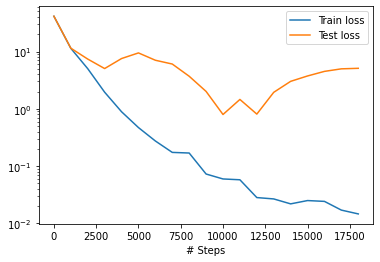

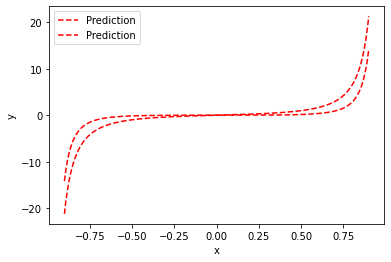

In [ ]:
dde.saveplot(losshistory, train_state, issave=True, isplot=True)


Expected:  	 ω_r =  0.5 		 ω_i = -3.5
Predicted:  	 ω_r =  0.48971036 	 ω_i = -3.457518
	 Error ω_r :  0.020579278 	 Error ω_i :  0.012137685


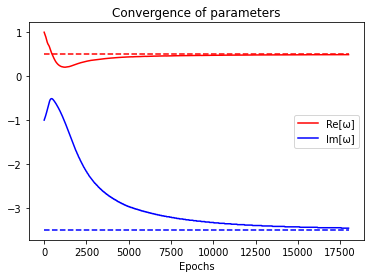

In [ ]:
#Parameters

print('Expected: ','\t ω_r = ',w_r_exp, "\t\t ω_i =", w_i_exp)
w_r_pre, w_i_pre, err1, err2 = variable.get_value()
print('Predicted: ','\t ω_r = ',w_r_pre, "\t ω_i =", w_i_pre)

print ('\t Error ω_r : ', err1,'\t Error ω_i : ', err2)

#Plots
lines = open(fnamevar, "r").readlines()
Chat = np.array(
    [
        np.fromstring(
            min(re.findall(re.escape("[") + "(.*?)" + re.escape("]"), line), key=len),
            sep=",",
        )
        for line in lines
    ]
)
l, c = Chat.shape
plt.plot(range(0, l * T, T), Chat[:, 0], "r-")
plt.plot(range(0, l * T, T), Chat[:, 1], "b-")
plt.plot(range(0, l * T, T), np.ones(Chat[:, 0].shape)*w_r_exp , "r--")
plt.plot(range(0, l * T, T), np.ones(Chat[:, 1].shape)*w_i_exp , "b--")
plt.title('Convergence of parameters')
plt.legend(["Re[ω]", "Im[ω]"], loc="right")
plt.xlabel("Epochs")
plt.show()

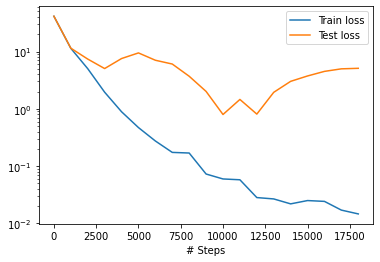

In [ ]:
dde.utils.external.plot_loss_history(losshistory)

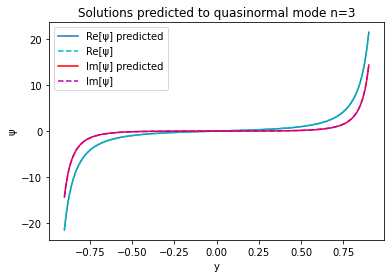

In [ ]:
x = geom.uniform_points(1000)
y = model.predict(x)

u_pred, v_pred = y[:, 0:1], y[:, 1:2]

with tf.Session() as sess: 
    array_u = sess.run(func_r(x))
    array_v = sess.run(func_i(x))

f_u = np.array(array_u)
f_v = np.array(array_v)

plt.figure()
plt.plot(x, f_u, "-", label="Re[ψ] predicted")
plt.plot(x, u_pred, "c--", label="Re[ψ]")
plt.plot(x, f_v, "r-", label="Im[ψ] predicted")
plt.plot(x, v_pred, "m--", label="Im[ψ]")

plt.title('Solutions predicted to quasinormal mode n=3')
plt.xlabel("y")
plt.ylabel('ψ')
plt.legend()

plt.show()